# Emotion Detection

This program implements a model with Keras using tensorflow backend to detect if someone's emotion is classified as "happy" or "not happy."

The dataset is labeled. 
<img src="images/faces.png" style="width:550px;height:250px;">

Version notes: tensorflow v1.4.0, scipy v1.1.0, numpy v1.16.4 (downgraded for incompatibility with tf)

In [1]:
import numpy as np
from keras import layers, regularizers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential, load_model
from keras.initializers import glorot_uniform
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning)

from kutils import *
from getdata import load_dataset

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import scipy.misc

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


In [2]:
train_file = 'train_happy.h5'
test_file = 'test_happy.h5'
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset(train_file, test_file) # from getdata

In [3]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


### Simple Sequential Model

In [4]:
def SimpleModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', then you can provide the input_shape using X_train.shape[1:]

    Returns:
    model -- a Model() instance in Keras
    """
    
    decay = 1e-4
    base = 32
    model = Sequential()
    model.add(Conv2D(base, (3,3), padding='same', kernel_regularizer=regularizers.l2(decay), input_shape=(input_shape,input_shape,3), name='conv0'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='bn0'))
    model.add(Conv2D(base, (3,3), padding='same', kernel_regularizer=regularizers.l2(decay), name='conv1'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='bn1'))
    model.add(MaxPooling2D((2,2), name='max_pool1'))
    model.add(Dropout(0.2))
    model.add(Conv2D(2*base, (3,3), padding='same', kernel_regularizer=regularizers.l2(decay), name='conv2'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='bn2'))
    model.add(Conv2D(2*base, (3,3), padding='same', kernel_regularizer=regularizers.l2(decay), name='conv3'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='bn3'))
    model.add(MaxPooling2D((2,2), name='max_pool2'))
    model.add(Dropout(0.3))
    model.add(Conv2D(4*base, (3,3), padding='same', kernel_regularizer=regularizers.l2(decay), name='conv4'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='bn4'))
    model.add(Conv2D(4*base, (3,3), padding='same', kernel_regularizer=regularizers.l2(decay), name='conv5'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='bn5'))
    model.add(MaxPooling2D((2,2), name='max_pool3'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1, activation='softmax', name='fc'))
    model.summary()
    
    
    return model

In [5]:
model = SimpleModel(64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
__________

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=16, epochs=2, validation_data=(X_test, Y_test), shuffle=True)

Train on 600 samples, validate on 150 samples
Epoch 1/2
600/600 [==============================] - 32s 54ms/step - loss: 7.9886 - acc: 0.5000 - val_loss: 7.0198 - val_acc: 0.5600
Epoch 2/2
600/600 [==============================] - 33s 55ms/step - loss: 7.9733 - acc: 0.5000 - val_loss: 7.0152 - val_acc: 0.5600


In [7]:
# model.save('models/SimpleModel.h5')

In [8]:
model = load_model('models/SimpleModel.h5')

In [9]:
preds = model.evaluate(X_test, Y_test)

150/150 [==============================] - 3s 18ms/step


[[1.]]


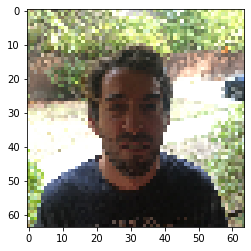

In [10]:
img_path = 'images/person.jpg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(model.predict(x))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 32)        0         
__________

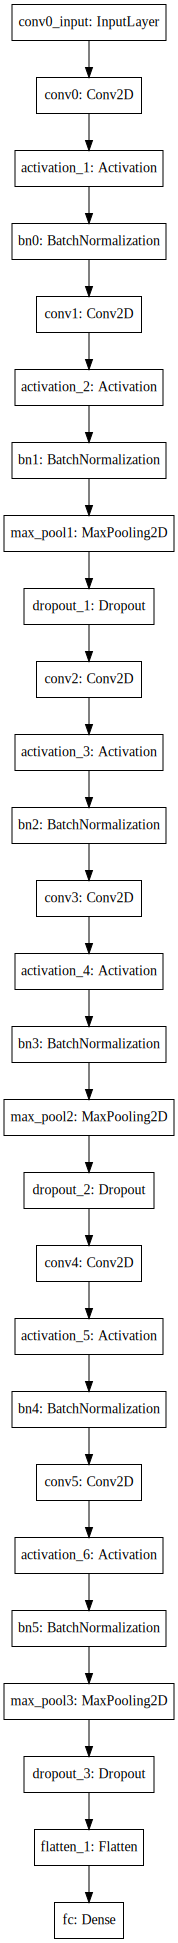

In [12]:
plot_model(model, to_file='output/Model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))